# Lab 05


In [1]:
# %%capture doesn't display output
# %%capture
# !wget https://github.com/dbdmg/data-science-lab/raw/master/datasets/NYC_POIs.zip -O nyc_poi.zip
# !wget https://github.com/dbdmg/data-science-lab/raw/master/datasets/US_FlightDelayData.zip -O fdd.zip

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## New York Point Of Interest

The _New York Point Of Interest_ dataset collects a sub-sample of the point of interests (POI) available in
the city of New York. It contains the coordinates of each point of interest and the category to which it
belongs to, specifying the _type_ of the POI, for each POI _category_. There are _four_ possible categories of POIs:
_amenity, shop, public_transport_ and _highway_.
The fields available in the dataset are:
- `@id`: a unique id for each point of interest.
- `@lat`: latitude coordinate of the POI in decimal degrees.
- `@lon`: longitude coordinate of the POI in decimal degrees.
- `amenity name`: if the POI category is amenity its type is reported in this field.
- `shop`: if the POI category is shop its type is reported in this field.
- `public_transport`: if the POI category is public transport its type is reported in this field.
- `highway`: if the POI category is highway its type is reported in this field.
  
To identify which are the POIs belonging only to the New York City municipality, a further file is provided. The _New York City municipality POIs metadata_ file is composed by a single column containing the Ids of the POI of interest of the municipality.

In [3]:
from zipfile import ZipFile

with ZipFile('nyc_poi.zip', 'r') as zipfile:
    zipfile.printdir()

File Name                                             Modified             Size
New_York_City_Map.PNG                          2019-11-07 13:54:28        87105
__MACOSX/._New_York_City_Map.PNG               2019-11-07 13:54:28          211
ny_municipality_pois_id.csv                    2019-11-07 15:50:52       581601
__MACOSX/._ny_municipality_pois_id.csv         2019-11-07 15:50:52          267
pois_all_info                                  2019-11-07 14:56:46      4787894
__MACOSX/._pois_all_info                       2019-11-07 14:56:46          267


In [4]:
files_to_extract = ['New_York_City_Map.PNG', 'ny_municipality_pois_id.csv', 'pois_all_info']
with ZipFile('nyc_poi.zip', 'r') as zipfile:
    for file in files_to_extract:
        zipfile.extract(file)

In [6]:
nyc_df = pd.read_csv('pois_all_info',  sep='\t')
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   @id               77884 non-null  int64  
 1   @type             77884 non-null  object 
 2   @lat              75789 non-null  float64
 3   @lon              75789 non-null  float64
 4   amenity           32271 non-null  object 
 5   name              40790 non-null  object 
 6   shop              12850 non-null  object 
 7   public_transport  10390 non-null  object 
 8   highway           9445 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.3+ MB


/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_912/3240295855.py:1: DtypeWarning: Columns (4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_df = pd.read_csv('pois_all_info',  sep='\t')


In [7]:
import csv
ids = []
with open('ny_municipality_pois_id.csv', 'r') as f:
    for col in csv.reader(f):
        # print(col)
        ids.append(int(col[0]))

In [8]:
# Data Cleaning
# Since each poi has unique id, 
# we have to check which row we have to keep.
# Some ids are repeated
mask = nyc_df['@id'].value_counts() > 1

cnt = mask.sum()
duplicated_ids = mask.iloc[:cnt].index

ids_remove = []
# The second id that is repeated contains less informations. 
# Hence we keep the index and we will remove it
for id in duplicated_ids:
    ids_remove.append((nyc_df[nyc_df['@id'] == id]).index[1])
    
# Obtain same result using drop_duplicates

In [9]:
(nyc_df.drop_duplicates(subset='@id', keep='first', )['@id'].value_counts() == 2).sum()

0

In [10]:
# since it works, we can use inplace=True
nyc_df.drop_duplicates(subset='@id', keep='first', inplace=True)
# Now we can set @id as index and then filter the nyc ids
nyc_df.set_index(keys='@id', inplace=True)

In [11]:
filtered_df = nyc_df.loc[ids]

In [12]:
filtered_df.info() #check inferred types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53530 entries, 42432939 to 6146672068
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   @type             53530 non-null  object 
 1   @lat              53530 non-null  float64
 2   @lon              53530 non-null  float64
 3   amenity           24712 non-null  object 
 4   name              30550 non-null  object 
 5   shop              8717 non-null   object 
 6   public_transport  8376 non-null   object 
 7   highway           7559 non-null   object 
dtypes: float64(2), object(6)
memory usage: 3.7+ MB


In [12]:
filtered_df.head()

,@type,@lat,@lon,amenity,name,shop,public_transport,highway
@id,,,,,,,,
42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN
42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN
42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN
42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN
42811266,node,40.704806,-73.772734,NaN,NaN,NaN,stop_position,NaN


In [13]:
# check where and how many null values you have
for column in filtered_df.columns:
    print(column, filtered_df[column].isna().sum())

@type 0
@lat 0
@lon 0
amenity 28818
name 22980
shop 44813
public_transport 45154
highway 45971


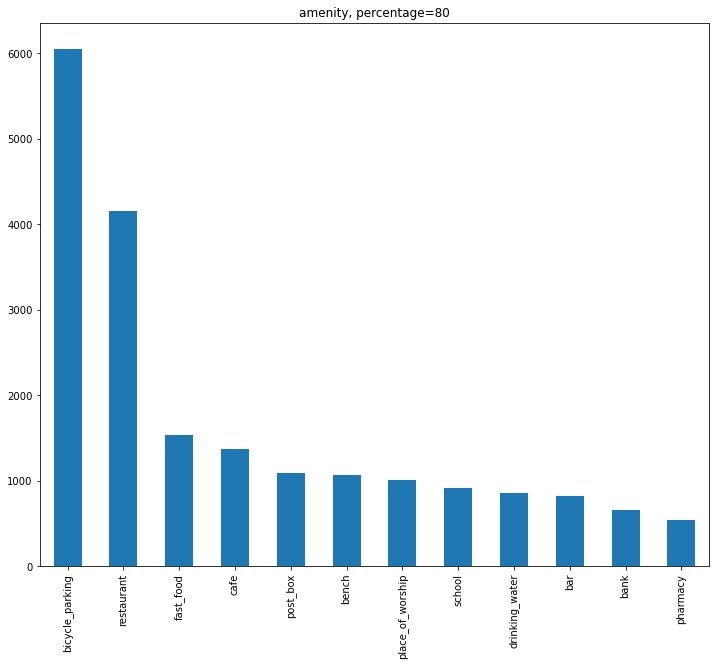

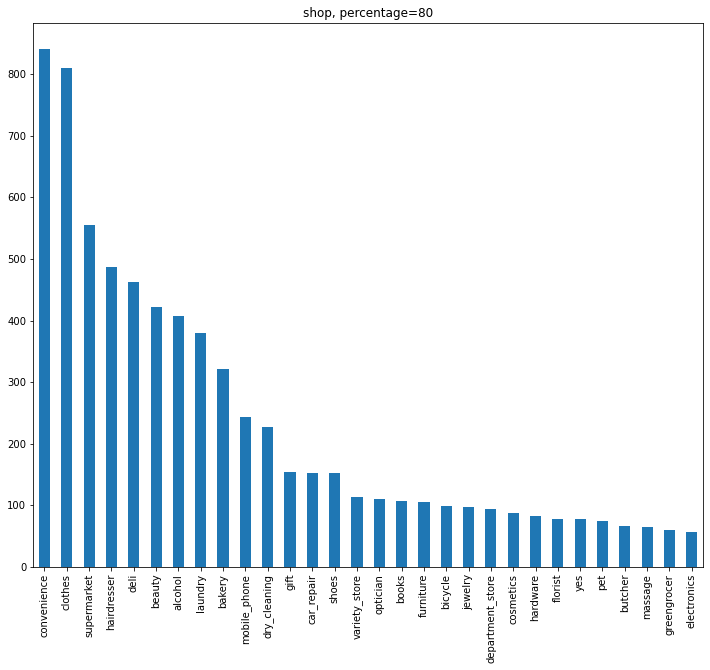

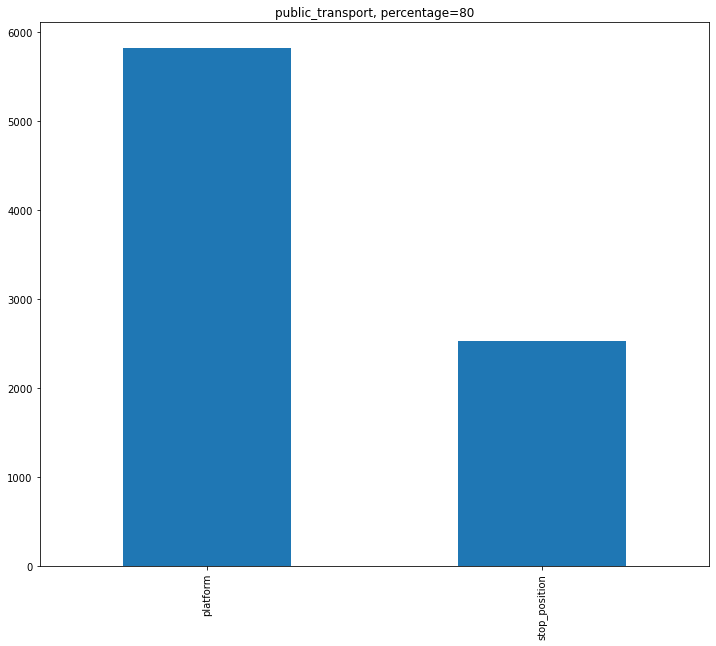

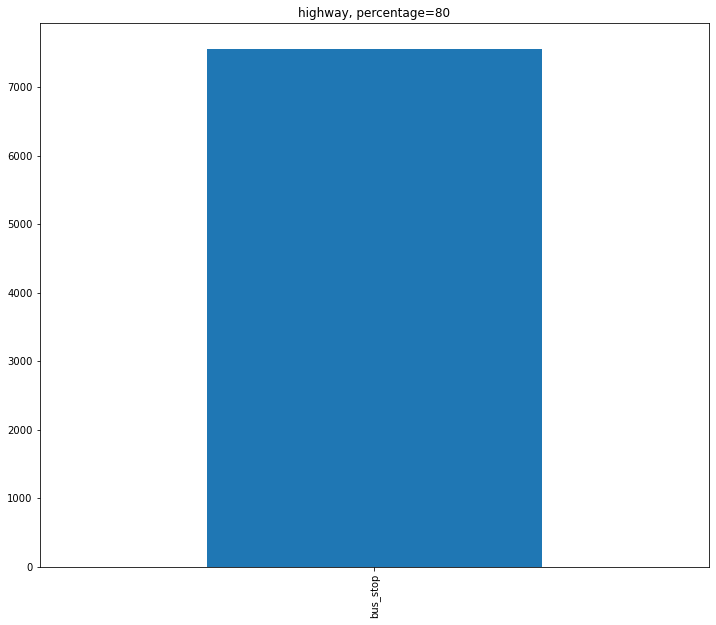

In [14]:
def plot_column_hist(df:pd.DataFrame, column:str, percentage:float=0.5):
    serie = df[column].value_counts()
    percentage=percentage
    # seleziono quelli che non rientrano nell'80% dei casi. 
    # l'indice sarà il valore oltre il quale non ho più l'80% dei casi
    idx = (serie.cumsum()/serie.sum() > percentage).values.argmax()
    plt.figure(figsize=(12,10))

    serie.iloc[:idx + 1].plot(kind='bar', title=f'{column}, percentage={percentage*100:.0f}')


columns_to_plot = ['amenity', 'shop', 'public_transport', 'highway']
for col in columns_to_plot:
    plot_column_hist(filtered_df, col, 0.8)

In [15]:
def top_percentage(df:pd.DataFrame, column:str, percentage:float=0.5):
    serie = df[column].value_counts()
    idx = (serie.cumsum()/serie.sum() > percentage).values.argmax()
    return serie.iloc[:idx + 1]

In [16]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

def plot_category(column:str, df:pd.DataFrame, cmap:'str'='viridis', title:str='prova', format:str='png'):
    img = plt.imread("New_York_City_Map.PNG")
    top = top_percentage(df, column, .8)
    arg = np.argwhere(df.columns == column).squeeze()
    selected_rows = []
    for idx, row in zip(df.index, df.values):
        if row[arg] in top.index:
            selected_rows.append(idx)
    cmap = get_cmap('viridis')
    x = np.linspace(0, 1, top.index.size)
    colors = cmap(x)
    most_freq = df.loc[selected_rows][['@lat', '@lon', column]]
    fig, ax = plt.subplots(figsize=(12,10))
    for i, kind in enumerate(top.index):
        prova = most_freq.loc[most_freq[column] == kind]
        c = [colors[i]] * len(prova)
        
        min_x, max_x = min(prova['@lon']) - .01, max(prova['@lon']) + .01
        min_y, max_y = min(prova['@lat']) - .01, max(prova['@lat']) + .01
        #ax.imshow(img, extent=[min_x, max_x, min_y, max_y])
        prova.plot(x='@lon', y='@lat', kind='scatter', c=c, label=kind, alpha=.5, ax=ax)
        plt.title(f'{column}')
        ax.imshow(img, extent=[min_x, max_x, min_y, max_y])
        ax.legend()
        plt.savefig(f'{title}.{format}', format=format)

In [17]:
columns_to_plot

['amenity', 'shop', 'public_transport', 'highway']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

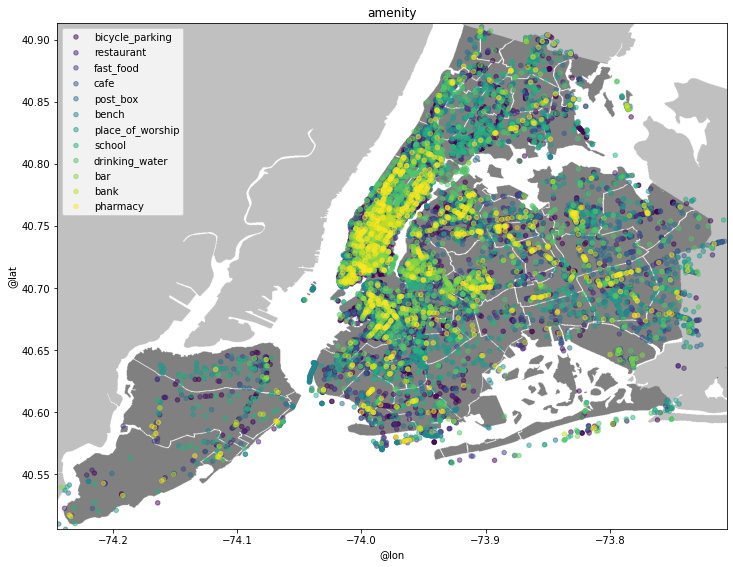

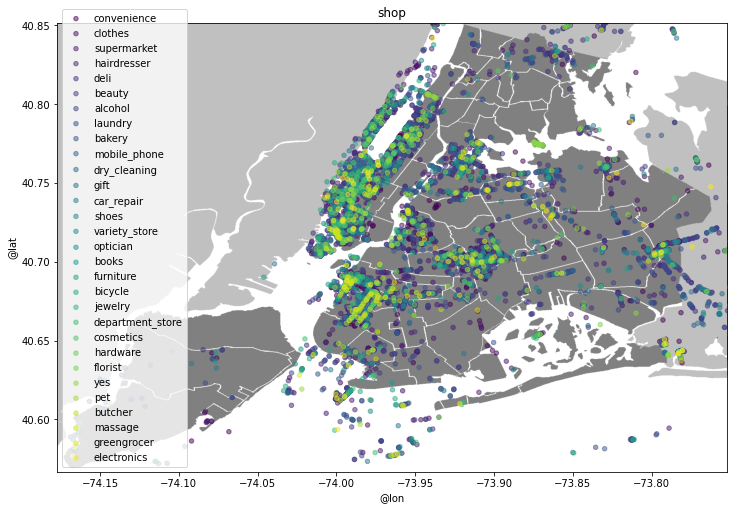

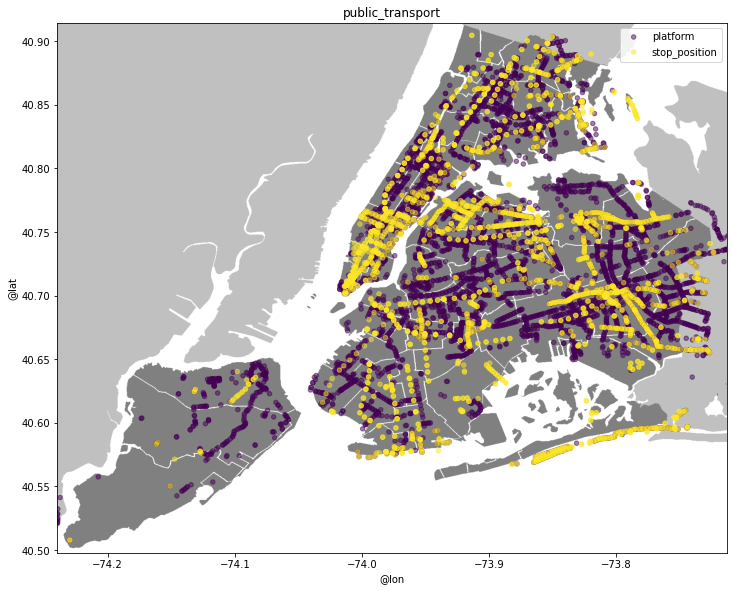

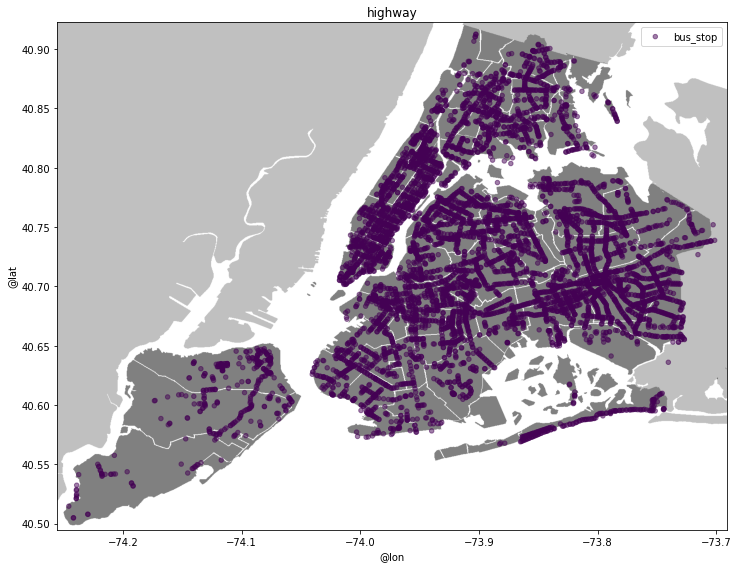

In [18]:
for column in columns_to_plot:
    plot_category(column, filtered_df, title=column, format='eps')

In [18]:
def find_cell(value:float, cell_dict:dict):
    min_val = (None, np.inf)
    for k,v in cell_dict.items():
        difference = np.abs(value - v)
        if difference < min_val[1]:
            min_val = (k,difference)
    return min_val[0]

class grid():
    
    def __init__(self, x:pd.Series, y:pd.Series, mxn:tuple):
        self.x = x
        self.y = y
        self.rows = mxn[0]
        self.columns = mxn[1]
            
    def grid_it(self):
        minx = min(self.x)
        maxx = max(self.x)
        self.xx = np.linspace(start=minx, stop=maxx, num=self.columns, endpoint=True)
        miny = min(self.y)
        maxy = max(self.y)
        self.yy = np.linspace(start=miny, stop=maxy, num=self.rows, endpoint=True) 
        self.XX, self.YY = np.meshgrid(self.xx,self.yy)
        self.dict_x = {k:v for k,v in enumerate(self.xx)}
        longitudes = [find_cell(i, self.dict_x) for i in self.x]
        self.dict_y = {k:v for k,v in enumerate(self.yy)}
        latitudes = [find_cell(i, self.dict_y) for i in self.y]
        return longitudes, latitudes
    
    def plot_grid(self, image_path:str, figsize:tuple=(12,10), **kwargs):
        fig, ax = plt.subplots(figsize=figsize)
        img = plt.imread(image_path)
        min_x, max_x = min(self.xx), max(self.xx)
        min_y, max_y = min(self.yy), max(self.yy)
        ax.hlines(self.yy, min_x, max_x, colors='k')
        ax.vlines(self.xx, min_y, max_y, colors='k')
        ax.imshow(img, extent=[min_x, max_x, min_y, max_y])    
    
    
     

In [19]:
# extract latitudes
lat = filtered_df['@lat']
# extract longitudes
lon = filtered_df['@lon']
# create a grid by passing longitudes as x and latitudes as y, 
# and a tuple containing number of rows and number of columns
g = grid(lon, lat, (10,10))
# extract discretized latitudes and longitudes
lons, lats = g.grid_it()
x = g.dict_x.keys()
y = g.dict_y.keys()
# create coordinates by joining longitude and latitude
coordinates = [(i,v) for i,v in zip(lons,lats)]
# create a dictionary that will map coordinates to id
map_dict = {v:k for k,v in enumerate(sorted(pd.Series(coordinates).value_counts().index))}

ids = pd.Series(coordinates).map(map_dict).values
filtered_df['id'] = ids
filtered_df['coordinates'] = coordinates

filtered_df.head()

,@type,@lat,@lon,amenity,name,shop,public_transport,highway,id,coordinates
@id,,,,,,,,,,
42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN,25,"(5, 7)"
42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN,24,"(5, 6)"
42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN,50,"(8, 8)"
42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN,34,"(6, 8)"
42811266,node,40.704806,-73.772734,NaN,NaN,NaN,stop_position,NaN,46,"(8, 4)"


In [20]:
filtered_df.rename(columns={'id':'cell_id'}, inplace=True) # rename id in cell_id as exercise requires

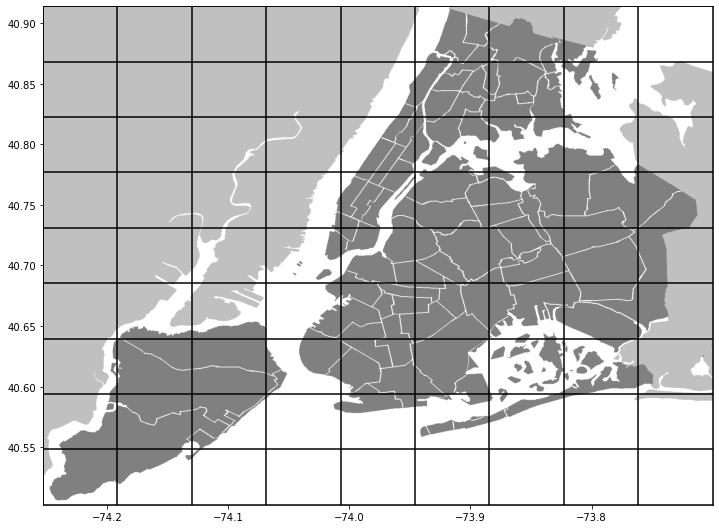

In [21]:
g.plot_grid('New_York_City_Map.PNG')

In [30]:
def discretized_category_df(category:str, df:pd.DataFrame) -> pd.DataFrame:
    dfs = []

    ids = sorted(df.cell_id.value_counts().index)
    for id in ids:
        mask = df['cell_id'] == id
        df_temp = pd.DataFrame(df[mask][category].value_counts()).T
        df_temp.rename(index={category:id}, inplace=True)
        dfs.append(df_temp)
    return pd.concat(dfs, axis=0)

In [52]:
disc_amenity_df = discretized_category_df('amenity', filtered_df)
disc_shop_df = discretized_category_df('shop', filtered_df)

Text(0.5, 1.0, 'amenity')

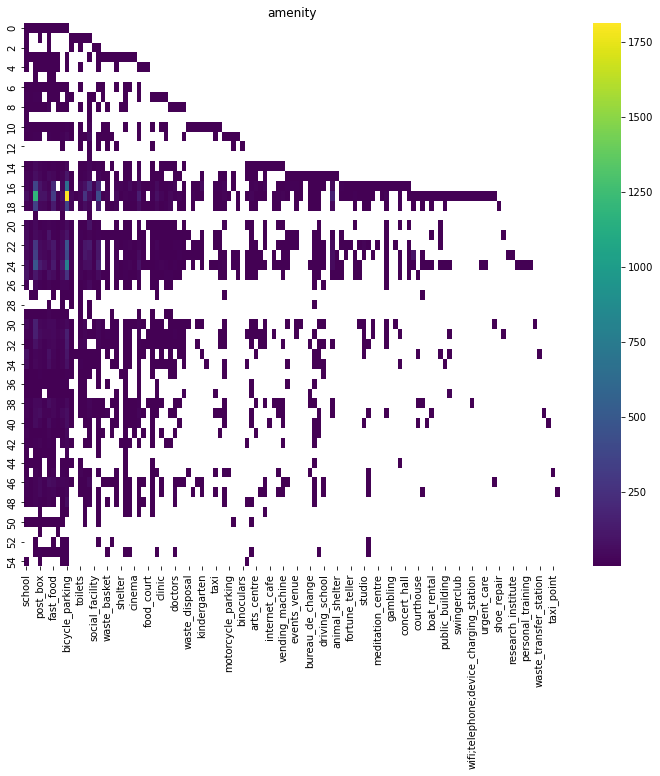

In [50]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(disc_amenity_df, cmap='viridis', ax=ax)
ax.set_title('amenity')


Text(0.5, 1.0, 'shop')

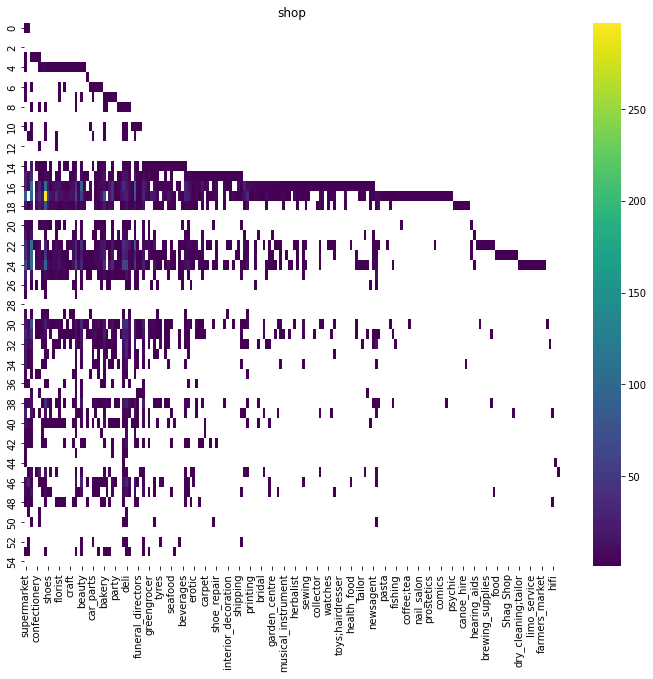

In [54]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(disc_shop_df, cmap='viridis', ax=ax)
ax.set_title('shop')

There are too many types, let's filter them

In [103]:
def filter_by_category_df(df:pd.DataFrame, category:str, perc:float=.8):
    top = top_percentage(df, category, perc)
    arg = np.argwhere(df.columns == category).squeeze()
    selected_rows = []
    for idx, row in zip(df.index, df.values):
        if row[arg] in top.index:
            selected_rows.append(idx)
    return df.loc[selected_rows]
    
disc_amenity_df = discretized_category_df('amenity', filter_by_category_df(filtered_df, 'amenity', .6))
disc_shop_df = discretized_category_df('shop', filter_by_category_df(filtered_df, 'shop', .6))

Text(0.5, 1.0, 'amenity (filtered at 60%)')

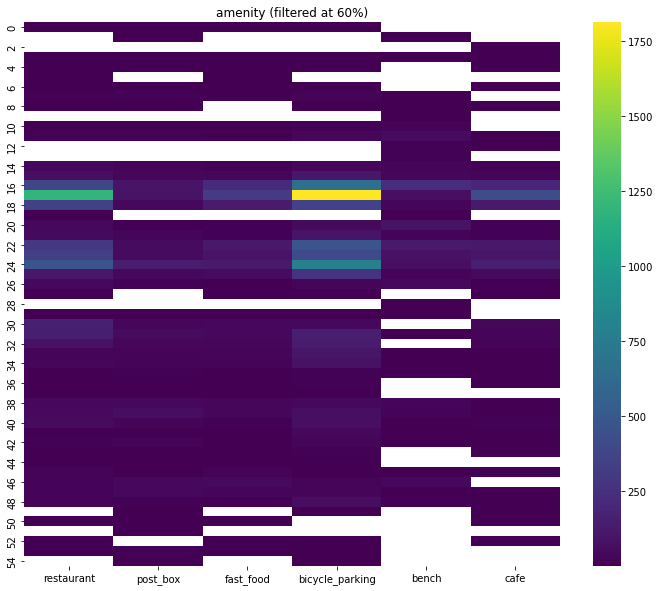

In [104]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(disc_amenity_df, cmap='viridis', ax=ax)
ax.set_title('amenity (filtered at 60%)')

Text(0.5, 1.0, 'shop (filtered at 60%)')

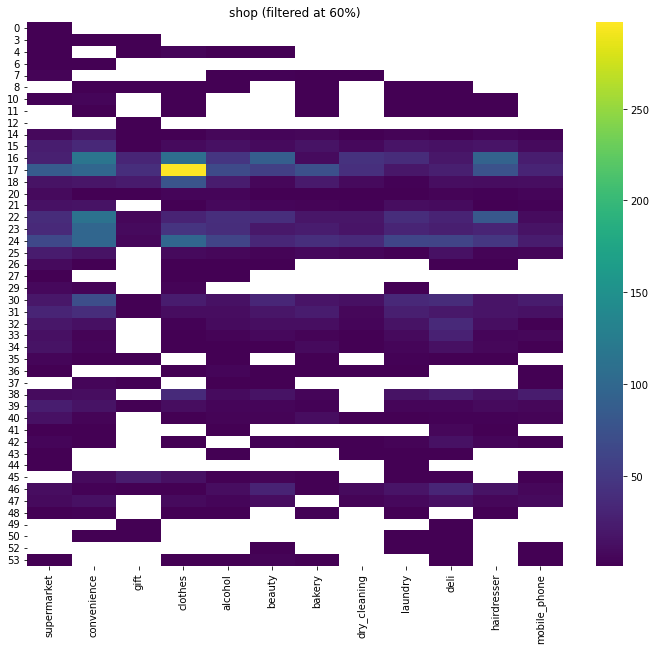

In [105]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(disc_shop_df, cmap='viridis', ax=ax)
ax.set_title('shop (filtered at 60%)')

<AxesSubplot:>

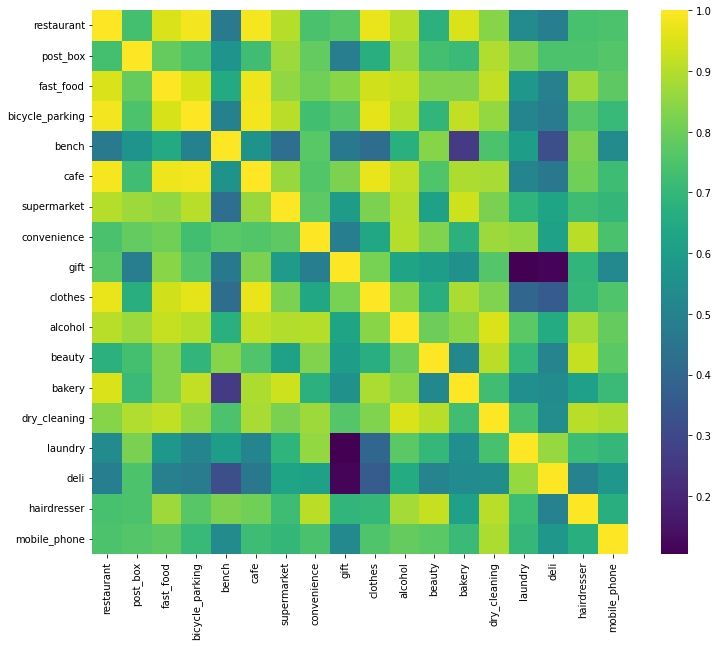

In [106]:
final_df = pd.concat([disc_amenity_df, disc_shop_df], axis=1)
corr_df = final_df.corr()

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_df, ax=ax, cmap='viridis')

## Flight Delay Data

Measuring the performance of flight carriers (e.g. American Airlines, EasyJet) is extremely important for
the transportation department and, for this reason, all the information related to each flight are constantly
monitored and collected in huge databases by the Department of Transportation. To the aim of this laboratory, just a small set of information has been extracted.

The dataset contains the Carrier On-Time Performance information collected from 01-01-2017 until 31-01-2017 for all the flights in the United States. Each row represents a flight in a specific day.

Some of the most useful fields in the dataset are:
- `FL_DATE`: day of the flight in format YYYY-mm-dd.
- `TAIL_NUM`: aircraft registration number, unique to a single aircraft.
- `UNIQUE_CARRIER`: flight carrier id.
- `FL_NUM`: number of the flight.
- `ORIGIN`: departure airport code.
- `DEST`: destination airport code.
- `CRS_DEP_TIME`: scheduled departure time (local time: HHMM) shown in the carriers’ Computerized
Reservations Systems (CRS)
- `DEP_TIME`: actual departure time (local time: HHMM)
- `DEP_DELAY`: overall delay at departure. Difference in minutes (floating point number) between sched-
uled and actual departure time. Early departures set to 0.
- `CRS_ARR_TIME`: scheduled arrival time (local time: HHMM) shown in the carriers’ Computerized
Reservations Systems (CRS)
- `ARR_TIME`: actual arrival time (local time: HHMM)
- `ARR_DELAY`: overall delay. Difference in minutes (floating point number) between scheduled and
actual arrival time. Early arrivals show negative numbers.
- `CARRIER_DELAY`: delay in minutes (floating point number) caused by the carrier.
- `WEATHER_DELAY`: delay in minutes (floating point number) caused by the weather.
- `NAS_DELAY`: delay in minutes (floating point number) caused by the National Air System (NAS).
- `SECURITY_DELAY`: delay in minutes (floating point number) caused by the security.
- `LATE_AIRCRAFT_DELAY`: delay in minutes (floating point number) caused by the aircraft.

There are some other fields in this dataset. You can explore them, understand what they represents and
whether they are significant or not for your analysis.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline


In [1]:
from zipfile import ZipFile

with ZipFile('fdd.zip', 'r') as zipfile:
    zipfile.printdir()

File Name                                             Modified             Size
831394006_T_ONTIME.csv                         2019-12-10 05:10:20     92160796


In [2]:
with ZipFile('fdd.zip', 'r') as zipfile:
    zipfile.extractall()

In [11]:
fdd_df = pd.read_csv('831394006_T_ONTIME.csv')
fdd_df.head()

,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,...,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32
0,2017-01-01,AA,19805,N787AA,1,12478,1247803,31703,JFK,"New York, NY",...,1209.0,27.0,0.0,NaN,27.0,0.0,0.0,0.0,0.0,NaN
1,2017-01-01,AA,19805,N783AA,2,12892,1289204,32575,LAX,"Los Angeles, CA",...,1809.0,42.0,0.0,NaN,34.0,0.0,8.0,0.0,0.0,NaN
2,2017-01-01,AA,19805,N791AA,4,12892,1289204,32575,LAX,"Los Angeles, CA",...,2040.0,42.0,0.0,NaN,7.0,0.0,0.0,0.0,35.0,NaN
3,2017-01-01,AA,19805,N391AA,5,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",...,1749.0,97.0,0.0,NaN,77.0,0.0,20.0,0.0,0.0,NaN
4,2017-01-01,AA,19805,N346AA,6,13830,1383002,33830,OGG,"Kahului, HI",...,642.0,42.0,0.0,NaN,0.0,0.0,42.0,0.0,0.0,NaN


In [12]:
fdd_df.describe()

,AIRLINE_ID,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32
count,450017.000000,450017.000000,450017.000000,4.500170e+05,450017.000000,450017.000000,4.500170e+05,450017.000000,450017.000000,441476.000000,...,450017.000000,440746.000000,439645.000000,450017.000000,97699.000000,97699.000000,97699.000000,97699.000000,97699.000000,0.0
mean,19900.483275,2079.643193,12698.267568,1.269830e+06,31738.603264,12698.024626,1.269805e+06,31738.404640,1327.757407,1333.947392,...,1506.278285,1487.332958,6.954484,0.019746,20.308836,3.368857,15.742495,0.079745,24.947492,NaN
std,385.381448,1722.700045,1534.326936,1.534324e+05,1286.063689,1534.246611,1.534244e+05,1285.791081,481.548320,494.957196,...,501.853851,523.821795,49.595992,0.139126,60.649157,27.809756,32.328181,2.896287,47.850860,NaN
min,19393.000000,1.000000,10135.000000,1.013503e+06,30070.000000,10135.000000,1.013503e+06,30070.000000,5.000000,1.000000,...,1.000000,1.000000,-98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,19690.000000,679.000000,11292.000000,1.129202e+06,30647.000000,11292.000000,1.129202e+06,30647.000000,917.000000,921.000000,...,1120.000000,1108.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,19805.000000,1602.000000,12892.000000,1.289204e+06,31454.000000,12892.000000,1.289204e+06,31454.000000,1321.000000,1330.000000,...,1529.000000,1521.000000,-5.000000,0.000000,0.000000,0.000000,4.000000,0.000000,3.000000,NaN
75%,20304.000000,3034.000000,14057.000000,1.405702e+06,32467.000000,14057.000000,1.405702e+06,32467.000000,1730.000000,1738.000000,...,1921.000000,1921.000000,11.000000,0.000000,17.000000,0.000000,20.000000,0.000000,31.000000,NaN
max,21171.000000,7439.000000,16218.000000,1.621801e+06,35991.000000,16218.000000,1.621801e+06,35991.000000,2359.000000,2400.000000,...,2359.000000,2400.000000,1944.000000,1.000000,1934.000000,1934.000000,1457.000000,653.000000,1392.000000,NaN


In [13]:
fdd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450017 entries, 0 to 450016
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   FL_DATE                450017 non-null  object 
 1   UNIQUE_CARRIER         450017 non-null  object 
 2   AIRLINE_ID             450017 non-null  int64  
 3   TAIL_NUM               449378 non-null  object 
 4   FL_NUM                 450017 non-null  int64  
 5   ORIGIN_AIRPORT_ID      450017 non-null  int64  
 6   ORIGIN_AIRPORT_SEQ_ID  450017 non-null  int64  
 7   ORIGIN_CITY_MARKET_ID  450017 non-null  int64  
 8   ORIGIN                 450017 non-null  object 
 9   ORIGIN_CITY_NAME       450017 non-null  object 
 10  DEST_AIRPORT_ID        450017 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    450017 non-null  int64  
 12  DEST_CITY_MARKET_ID    450017 non-null  int64  
 13  DEST                   450017 non-null  object 
 14  DEST_CITY_NAME         450017 non-nu

column 32 is useless, hence we remove it

In [15]:
fdd_df.drop('Unnamed: 32', axis=1, inplace=True)

In [18]:
fdd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450017 entries, 0 to 450016
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   FL_DATE                450017 non-null  object 
 1   UNIQUE_CARRIER         450017 non-null  object 
 2   AIRLINE_ID             450017 non-null  int64  
 3   TAIL_NUM               449378 non-null  object 
 4   FL_NUM                 450017 non-null  int64  
 5   ORIGIN_AIRPORT_ID      450017 non-null  int64  
 6   ORIGIN_AIRPORT_SEQ_ID  450017 non-null  int64  
 7   ORIGIN_CITY_MARKET_ID  450017 non-null  int64  
 8   ORIGIN                 450017 non-null  object 
 9   ORIGIN_CITY_NAME       450017 non-null  object 
 10  DEST_AIRPORT_ID        450017 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    450017 non-null  int64  
 12  DEST_CITY_MARKET_ID    450017 non-null  int64  
 13  DEST                   450017 non-null  object 
 14  DEST_CITY_NAME         450017 non-nu

In [31]:
columns = fdd_df.columns
col_with_nan = dict()
for col in columns:
    num_nan = fdd_df[col].isna().sum()
    if num_nan == 0:
        continue
    col_with_nan[col] = num_nan
    # print(col, num_nan)

col_with_nan

{'TAIL_NUM': 639,
 'DEP_TIME': 8541,
 'DEP_DELAY': 8541,
 'TAXI_OUT': 8773,
 'WHEELS_OFF': 8773,
 'WHEELS_ON': 9271,
 'TAXI_IN': 9271,
 'ARR_TIME': 9271,
 'ARR_DELAY': 10372,
 'CANCELLATION_CODE': 441131,
 'CARRIER_DELAY': 352318,
 'WEATHER_DELAY': 352318,
 'NAS_DELAY': 352318,
 'SECURITY_DELAY': 352318,
 'LATE_AIRCRAFT_DELAY': 352318}

In [35]:
num_unique_carriers = fdd_df.UNIQUE_CARRIER.nunique()
num_unique_carriers

12

In [40]:
origin_airport_set = fdd_df['ORIGIN_AIRPORT_ID'].unique()
len(origin_airport_set)
dest_airport_set = fdd_df['DEST_AIRPORT_ID'].unique()
len(dest_airport_set)

297

In [53]:
num_unique_airports = len(set(list(origin_airport_set) + list(dest_airport_set)))
num_unique_airports

298

In [60]:
fl_date = pd.to_datetime(fdd_df['FL_DATE'], yearfirst=True)
fl_date.unique()[[0,-1]]

array(['2017-01-01T00:00:00.000000000', '2017-01-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

recorded flights span from 1 january 2017 to 31 january 2017

In [68]:
mask = fdd_df['CANCELLED'] == 1
idxs_to_remove = []
for idx, val in zip(mask.index, mask.values):
    if val == True:
        idxs_to_remove.append(idx)

# check fdd_df.drop(idxs_to_remove, axis=0)['CANCELLED'].unique()
fdd_df.drop(idxs_to_remove, axis=0, inplace=True)


0.0

In [ ]:
# didn't run it since after it could be useful 
if fdd_df['CANCELLED'].sum() == 0:
    fdd_df.drop('CANCELLED', axis=1, inplace=True)

In [69]:
# how many flights had each carrier operated
fdd_df.groupby('UNIQUE_CARRIER').count()

,FL_DATE,AIRLINE_ID,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
UNIQUE_CARRIER,,,,,,,,,,,,,,,,,,,,,
AA,72152,72152,72152,72152,72152,72152,72152,72152,72152,72152,...,72152,72132,71947,72152,0,13999,13999,13999,13999,13999
AS,14454,14454,14454,14454,14454,14454,14454,14454,14454,14454,...,14454,14402,14386,14454,0,2964,2964,2964,2964,2964
B6,24077,24077,24077,24077,24077,24077,24077,24077,24077,24077,...,24077,24064,23968,24077,0,6061,6061,6061,6061,6061
DL,69031,69031,69031,69031,69031,69031,69031,69031,69031,69031,...,69031,69017,68842,69031,0,12507,12507,12507,12507,12507
EV,33878,33878,33878,33878,33878,33878,33878,33878,33878,33878,...,33878,33848,33732,33878,0,8236,8236,8236,8236,8236
F9,7598,7598,7598,7598,7598,7598,7598,7598,7598,7598,...,7598,7594,7579,7598,0,2205,2205,2205,2205,2205
HA,6258,6258,6258,6258,6258,6258,6258,6258,6258,6258,...,6258,6257,6251,6258,0,875,875,875,875,875
NK,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,...,12129,12117,12110,12129,0,2957,2957,2957,2957,2957
OO,48266,48266,48266,48266,48266,48266,48266,48266,48266,48266,...,48266,48115,47994,48266,0,12386,12386,12386,12386,12386


In [74]:
delay_columns = ['UNIQUE_CARRIER']
for column in fdd_df.columns:
    splitted_col = column.split('_')
    if splitted_col[-1] == 'DELAY':
        delay_columns.append(column)
delay_columns

['UNIQUE_CARRIER',
 'DEP_DELAY',
 'ARR_DELAY',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY']

In [75]:
fdd_df[delay_columns].groupby('UNIQUE_CARRIER').mean() # in minutes

,DEP_DELAY,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
UNIQUE_CARRIER,,,,,,,
AA,7.466917,3.307004,18.736410,2.352168,15.370026,0.178156,18.742267
AS,5.220769,3.311553,11.736505,3.820850,18.615047,0.169028,19.189946
B6,14.132533,8.423231,20.297641,1.436562,15.223725,0.312820,29.282627
DL,13.512205,4.305279,30.858959,9.572160,16.836252,0.033901,21.964020
EV,17.687791,13.173011,36.329407,1.368504,15.794439,0.000000,31.725109
F9,16.566333,12.076791,16.748299,0.870295,19.070295,0.000000,31.091610
HA,2.916427,3.617181,29.941714,0.897143,0.251429,0.122286,14.113143
NK,11.680600,8.993642,9.080825,0.732499,43.840041,0.035171,12.137978
OO,15.194941,12.528524,23.495640,4.633053,15.186582,0.100759,31.316244


In [96]:
# we exploit fl_date computed above.
# We need to compute it again since we removed some rows
fl_date = pd.to_datetime(fdd_df['FL_DATE'], yearfirst=True)
dow = fl_date.dt.day_of_week
days = ['monday', 'tuesday', 'wednsday', 'thursday', 'friday', 'saturday', 'sunday']
dow_dict = {k:v for k,v in enumerate(days)}
dow.map(dow_dict)

0          sunday
1          sunday
2          sunday
3          sunday
4          sunday
           ...   
450012    tuesday
450013    tuesday
450014    tuesday
450015    tuesday
450016    tuesday
Name: FL_DATE, Length: 441131, dtype: object

In [97]:
delay_delta = fdd_df['ARR_DELAY'] - fdd_df['DEP_DELAY']
delay_delta

0         -4.0
1          8.0
2         -9.0
3         20.0
4         42.0
          ... 
450012    13.0
450013   -18.0
450014     1.0
450015   -19.0
450016    -7.0
Length: 441131, dtype: float64

In [98]:
fdd_df['dow'] = dow
fdd_df['dow_ext'] = dow.map(dow_dict)
fdd_df['delaydelta'] = delay_delta

In [100]:
fdd_df[['dow_ext', 'delaydelta']].groupby('dow_ext').describe()


delaydelta                                                   
              count      mean        std    min   25%  50%  75%    max
dow_ext                                                               
friday      59902.0 -4.981520  15.388157  -74.0 -13.0 -6.0  2.0  473.0
monday      75293.0 -4.635278  14.885242 -106.0 -13.0 -6.0  3.0  156.0
saturday    45319.0 -5.172003  15.927086  -72.0 -14.0 -7.0  2.0  187.0
sunday      67816.0 -4.533665  16.299339  -71.0 -14.0 -6.0  2.0  207.0
thursday    60525.0 -5.253333  14.384433  -80.0 -14.0 -6.0  2.0  129.0
tuesday     72290.0 -5.596265  14.546016  -76.0 -14.0 -6.0  1.0  139.0
wednsday    58500.0 -5.363538  14.697455  -73.0 -14.0 -6.0  2.0  158.0

<AxesSubplot:xlabel='dow_ext', ylabel='delaydelta'>

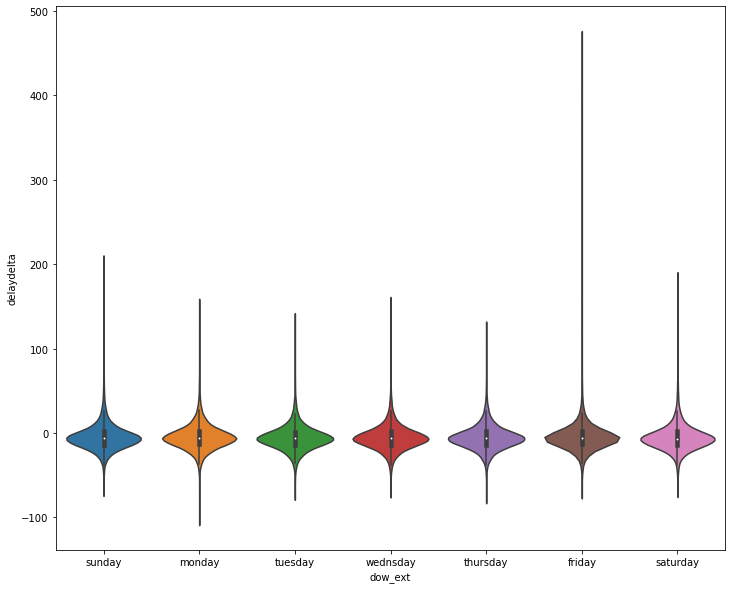

In [105]:
fig, ax = plt.subplots(figsize=(12,10))
sns.violinplot(x=fdd_df['dow_ext'], y=fdd_df['delaydelta'], ax=ax)